# グラフ埋め込み

In [1]:
import numpy as np
import networkx as nx

%matplotlib inline

In [2]:
DRAW_CONFIG = {
    'node_color': 'white',
    'edgecolors': 'black', # line color of nodes
    'with_labels': True,
    'node_size': 600,
    'font_size': 14,
    'font_family': 'Arial',
}

In [ ]:
try:
    import torch_geometric
except:
    !pip install torch_geometric

## 典型的なグラフ分析タスク
グラフ分析タスクといっても様々なものがあり，典型的なタスクとしては以下が挙げられる．

![](img/graph-analysis-tasks.jpg)

[第3講](content/centrality.ipynb)や[第4講](content/finding-community.ipynb)，[第5講](content/web-and-graph.ipynb)で学んだように，ノード中心性評価やコミュニティ発見のタスクに対しては，グラフ構造を踏まえたグラフ分析手法が提案されている．

ところで，コミュニティ発見はノード（あるいはエッジ）のクラスタリング（教師あり学習）タスクと見なせる．
また，ノード分類，エッジ分類，グラフ分類，ノード間の関係性予測も，分類/回帰問題（教師あり学習タスク）と見なせる．
そうであるならば，グラフ分析タスクにもK-means法やサポートベクターマシンといったような汎用的な機械学習手法を使えないのだろうか？

汎用的な機械学習手法は，入力としてベクトルデータを対象としている．
そのため，グラフやその構成要素であるノードやエッジを何らかの方法で**ベクトルに変換する**ことができれば，汎用的な機械学習手法を用いてグラフ分析タスクを解くことができる
（逆に，ベクトルデータもクラフ構造に変換できれば，グラフ分析特有の手法を適用することが可能となる）．

![](img/to-general-ml.jpg)


## グラフ埋め込み

対象の特徴を低次元の密ベクトルに変換したものを **埋め込み表現（Embedding）** あるいは単に**埋め込み**という．
大量のデータから質の良い埋め込み表現を得る行為は **表現学習（representation learning）** と呼ばれる．
グラフからも埋め込み表現を得ることが可能で，グラフあるいはその要素を低次元の密ベクトルに変換したものは **グラフ埋め込み（graph embedding）** と呼ばれる．

![](img/graph-embedding.jpg)

(simple-vectorization-of-node)=
### グラフノードをベクトル化する単純な方法

グラフ中のノードの特徴をベクトルとして表現する最も単純な方法は，隣接行列を用いるものである．
ノードがグラフ中にある他のノードと隣接しているか否かの情報は，ノードを特徴付ける単純かつ有力な情報である．

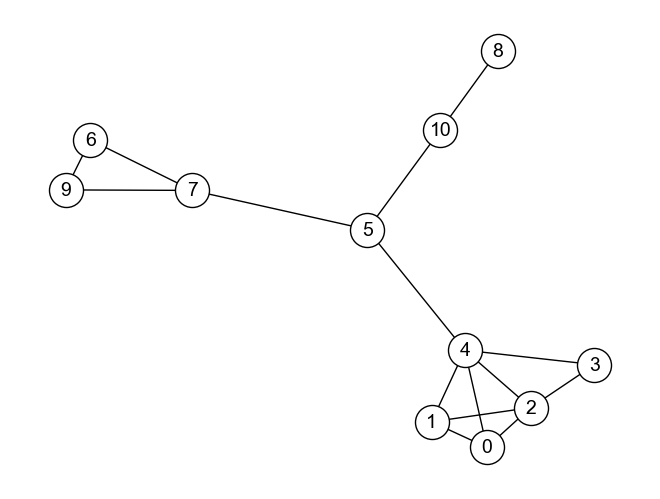

In [3]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
G.add_edges_from([
    (0, 1), (0, 2), (0, 4), (1, 2), (1, 4), (2, 3), (2, 4),
    (3, 4), (4, 5), (5, 7), (7, 6),  (7, 9), #(7, 8),
    (6, 9), #(8, 9)  #(7, 10), (8, 10), (9, 10)
    (5, 10), (8, 10) ##
])

pos = nx.spring_layout(G, seed=12345)
nx.draw(G, pos, **DRAW_CONFIG)

例として，上のグラフ$G$について考えてみよう．
このグラフ$G$の隣接行列$A$は

$$
A =
    \left(
    \begin{array}{ccccccccccc}
    0 & 1 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
    1 & 0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
    1 & 1 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
    1 & 1 & 1 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
    0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 \\
    \end{array}
    \right)
$$

である．
隣接行列において，$i$行は$i$番目のノードがどのノードと隣接しているかを示しており，$i$行の値の列を$i$番目のノードの特徴を示すベクトル$\boldsymbol{v}_i$と見なすことも可能である．
例えば，0番目のノードと6番目のノードのベクトルは，それぞれ

$$
\begin{eqnarray}
\boldsymbol{v}_0 = (0,1,1,0,1,0,0,0,0,0,0)^T \\
\boldsymbol{v}_6 = (0,0,0,0,0,0,0,1,0,1,0)^T
\end{eqnarray}
$$

である．
ベクトルの類似性を評価する一般的な方法のひとつは，コサイン類似度を見ることである．
0番目のノードと6番目のノードのベクトルのコサイン類似度は$sim_{cos}(\boldsymbol{v}_0, \boldsymbol{v}_6) = 0$ となり，グラフ上で互いに遠く離れたところにある0番目のノードと6番目のノードが計算上「似ていない」と評価されたことは，妥当であるように思われる．

同様に，0番目のノードと1番目のノードのベクトルは
$$
\begin{eqnarray}
\boldsymbol{v}_0 = (0,1,1,0,1,0,0,0,0,0,0)^T \\
\boldsymbol{v}_1 = (1,0,1,0,1,0,0,0,0,0,0)^T
\end{eqnarray}
$$

となり，その内積は$sim_{cos}(\boldsymbol{v}_0, \boldsymbol{v}_1)  = 0.667$ である．
0番目のノードと1番目のノードは隣接しているので，コサイン類似度が高くなることは妥当と思われる．

### 隣接行列の行をノードのベクトル表現として用いる問題点

しかし，4番目のノードと5番目のノードについてはどうだろうか．
4番目のノードと5番目のノードのベクトルは
$$
\begin{eqnarray}
\boldsymbol{v}_4 = (1,1,1,1,0,1,0,0,0,0,0)^T \\
\boldsymbol{v}_5 = (0,0,0,0,1,0,0,1,0,0,1)^T
\end{eqnarray}
$$

となり，その内積は$sim_{cos}(\boldsymbol{v}_4, \boldsymbol{v}_5) = 0$ で，隣り合っているので多少は似ていると思われるが類似度はゼロになってしまう．
何が問題だったのだろうか．

隣接行列の行をノードの特徴ベクトルとして用いる方法は，そのノードがどんなノードと隣接しているかによってノードを特徴づける．
またコサイン類似度の計算は，2つのノード間で共通している隣接ノードを調べている．
しかしながら，グラフにおけるノードの特徴は自身の隣接ノード**だけ**では決まらない．
隣接しているノードが他のどのノードと繋がっているのか，なども考慮する必要がある．
また，隣接行列の大部分の値はゼロである（隣接行列はスパース）．
スパースな行列やベクトルは情報量に乏しく，意味のある計算が難しい．
よって，単純に隣接行列を用いるのではなく，密であり，かつ特徴を捉えた良質なグラフ埋め込み表現を得る手法が必要となる．

## スペクトラルクラスタリング

**スペクトラルクラスタリング（spectral clustering）** は，グラフ中のノードの埋め込み表現を得る古典的手法の一つである．
スペクトラルクラスタリングでは，ノード間の接続関係に注目し，ある最適化問題を解くことでノードの埋め込み表現を獲得する．
元々は非グラフデータのクラスタリング手法として提案されたが，クラスタリング前の処理がグラフノードの埋め込み表現を得る手法として利用できる．


グラフ中の各ノードに何らかのスカラー値を割り当てることを考える．
ここで，条件として隣接しているノードにはできる限り近い値を割り当てたいとしよう．
すなわち，以下の図のように，あらゆるノード同士の値の差の絶対値を取ったときに，隣接しているノードについてはその差がゼロに近くなるようにしたい．
直感的には，差が小さいノード同士は同じようなグループに属すると考えることができる．

![](img/spectral-clustering.jpg)


### 問題の定式化
さて，対象とするグラフ$G$の隣接行列を$A$とすると，上記問題は

$$
L(\boldsymbol{x}) = \sum_{i,j \in V_G} A_{i, j} (x_i - x_j)^2
$$

の値を**最小化**する問題として定式化できる（$A_{i, j}$は隣接行列$A$の$i$行$j$列の値である）．
ここで，ノードに割り当てる値$x$は何も指定がないと無限に値を大きくすることができてしまう．
そのため，問題設定に

$$
x_1^2 + x_2^2 + ... + x_n^2 = |\boldsymbol{x}|^2 = 1
$$

という制約を加える．

さて，上記式$L(\boldsymbol{x})$を最小化する$\boldsymbol{x}$を見つけよう（**ここから先は最適化問題の解法なので，興味のない読者は「改めて問題定式化」まで読み飛ばしてください**）．
まず，式を以下のように変形する．

$$
\begin{eqnarray}
L(\boldsymbol{x}) &=& \sum_{i,j \in V_G} A_{i, j} (x_i - x_j)^2 \\
&=& \sum_{i,j \in V_G} A_{i, j} (x_i^2 -2 x_i x_j + x_j^2) \\
&=& \sum_{i,j \in V_G} A_{i, j} (x_i^2 + x_j^2)  -2 \sum_{i,j \in V_G} A_{i, j} x_i x_j  \\
\end{eqnarray}
$$

ここで，無向グラフの場合は隣接行列$A$は対称行列なので$A_{i, j} = A_{j, i}$．
このとき，$\sum_{i,j \in V_G}A_{i, j}x_i^2 = \sum_{i,j \in V_G}A_{j, i}x_i^2 = \sum_{i,j \in V_G}A_{j, j}x_j^2$ となる．
よって，

$$
\begin{eqnarray}
L(\boldsymbol{x}) &=& 2 (\sum_{i,j \in V_G} A_{i, j} x_i^2  - \sum_{i,j \in V_G} A_{i, j} x_i x_j)  \\
\end{eqnarray}
$$

ここで，$\sum_{j \in V_G}A_{i, j} = \sum_{j \in V_G} D_{i,i}$（$\boldsymbol{D}$は次数行列）とする．
式$L$の$\sum_{i, j \in V_G}A_{i,j}x_i^2$について，先に$j$に関する和を取ると，$\sum_{i,j \in V_G}A_{i, j}x_i^2 = \sum_{j \in V_G} D_{i,i}x_i^2$となるので，$L(\boldsymbol{x})$は以下のように書き直すことができる．

$$
\begin{eqnarray}
L(\boldsymbol{x}) &=& 2 (\sum_{i,j \in V_G} A_{i, j} x_i^2  - \sum_{i,j \in V_G} A_{i, j} x_i x_j)  \\
&=& 2 (\sum_{i,j \in V_G} D_{i, i} x_i^2  - \sum_{i,j \in V_G} A_{i, j} x_i x_j)  \\
&=& 2 (\boldsymbol{x}^T \boldsymbol{D} \boldsymbol{x} - \boldsymbol{x}^T \boldsymbol{A} \boldsymbol{x})  \\
\end{eqnarray}
$$
なお最後の行は，二次形式の数式の行列表現である．


### 改めて問題定式化

ここで，$\boldsymbol{\mathcal{L}} = \boldsymbol{D} - \boldsymbol{A}$ とすると，最終的に最小化したい$L(\boldsymbol{x})$は以下となる．

$$
L(\boldsymbol{x}) = 2 \boldsymbol{x}^T \boldsymbol{\mathcal{L}} \boldsymbol{x} \\
$$

この$L$を$|\boldsymbol{x}|^2 = 1$という条件下で最小化するのが，新たなゴールである．
さてさて，制約条件下における最小化問題といえば[ラグランジュの未定乗数法](https://ja.wikipedia.org/wiki/ラグランジュの未定乗数法)で解くのが鉄板である．
上記の最小化問題にラグランジュの未定乗数法を適用すると，$L$を最小化する$\boldsymbol{x}$は

$$
\frac{\partial}{\partial \boldsymbol{x}} (2 \boldsymbol{x}^T \boldsymbol{\mathcal{L}} \boldsymbol{x} - 2 \lambda(\boldsymbol{x}^T \boldsymbol{x}-1)) = 2 \boldsymbol{\mathcal{Lx}} - 2 \lambda \boldsymbol{x} = 0
$$

を解くことで求められる．これは$\boldsymbol{\mathcal{Lx}} = \lambda \boldsymbol{x}$ となる$\boldsymbol{x}$を求める問題，すなわち$\boldsymbol{\mathcal{L}}$ の固有値問題に帰着される．
さらに，この条件を満たす固有値が見つかったとすると，元々最小化したかった$L$は

$$
\begin{eqnarray}
L(\boldsymbol{x}) &=& 2 \boldsymbol{x}^T \boldsymbol{\mathcal{L}} \boldsymbol{x} \\
&=& 2 \boldsymbol{x}^T \lambda \boldsymbol{x} \\
&=& 2 \lambda \boldsymbol{x}^T  \boldsymbol{x} \\
&=& 2 \lambda \\
\end{eqnarray}
$$

となり，小さい固有値を選べば$L$もより小さくなる．
ここで，固有ベクトル$\boldsymbol{x}$の値は，各ノードに割り当てるスカラー値（の候補）を示している．
なお，最小の固有値はゼロであり，それに対応する固有ベクトルはその要素値がすべて同じになる．
これは，隣接しているか否かにかかわらず，すべてのノードが同じグループに属していると見なすことに相当する．

固有値計算の結果をもとにグラフ上のノードのいくつかのクラスタに分割したい場合，直感的には，ゼロでない固有値に対応する固有ベクトルの値をもとにその差が小さくなるようなグループ分けを見つければよい．
ただし，現実世界でもそうであるように，グラフ上のノードのグループも視点によって異なる．
実は，固有値計算によって複数得られるグラフラプラシアンの固有ベクトルは異なるグループ分けに対応しており，固有値が小さい固有ベクトルほど（グループ内での）要素値のばらつきが小さいことを意味している．

```{note}
ちなみに，$\boldsymbol{\mathcal{L}} = \boldsymbol{D} - \boldsymbol{A}$ はグラフラプラシアンと呼ばれ，グラフの特徴を表す重要な情報としてグラフ分析で頻出する．
```


### スペクトルクラスタリングによるグラフノードの埋め込み手順

上で説明したように，固有値に対応する固有ベクトルは，グラフ上のノードをある観点でグループ分けするための，各ノードの特徴を示す値の集合と見なすことができる．
そのため，固有値が小さい固有ベクトルに注目すれば，それをノードの特徴量として使える．

以下，スペクトルクラスタリングを用いて，グラフから各ノードの潜在的な特徴量（ノード埋め込み）を得る手順である：

1. グラフ$G$のラプラシアン$\boldsymbol{\mathcal{L}}=\boldsymbol{D} - \boldsymbol{A}$を取得
2. ラプラシアン$\boldsymbol{\mathcal{L}}$の固有値と固有ベクトルを計算する
3. 固有値を小さい順に並べる（$\boldsymbol{u}_0, \boldsymbol{u}_1, ..., \boldsymbol{u}_n$）．並べた結果から，ゼロではない固有有値を$K$個取り，各固有値に対応する固有ベクトル（縦）を横に並べたものをノード埋め込み行列（$\boldsymbol{X} = (\boldsymbol{u}_1, ..., \boldsymbol{u}_K)$）とする．
4. ノード埋め込み行列の$i$行目を$i$番目のノードの埋め込みベクトルとして扱う

例えば，3次元のノード埋め込みベクトルを得たい場合は，ゼロではない固有値を小さいもの順に3つ取得し，それに対応する3つの固有ベクトルを使ってノード埋め込み行列とする．
何番目までの固有値（固有ベクトル）に注目するかは，分析者次第である．

```{note}
ゼロの固有値に対応する固有ベクトルを使わない理由は，固有ベクトルの値がすべて同じになり，ノードの特徴付けに有用でないためである．
```

例として，[グラフノードをベクトル化する単純な方法](#simple-vectorization-of-node)で使ったグラフ$G$の各ノードの埋め込みベクトルを，スペクトラルクラスタリングによって求めてみよう．
以下，グラフ$G$を再掲しておく．

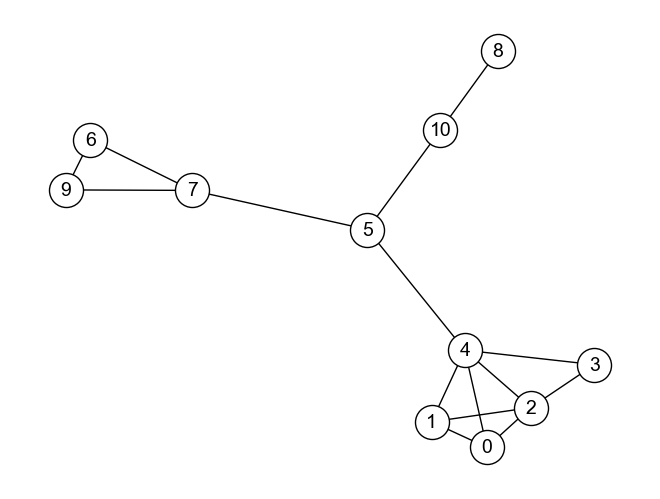

In [4]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
G.add_edges_from([
    (0, 1), (0, 2), (0, 4), (1, 2), (1, 4), (2, 3), (2, 4),
    (3, 4), (4, 5), (5, 7), (7, 6),  (7, 9), #(7, 8),
    (6, 9), 
    (5, 10), (8, 10) 
])

pos = nx.spring_layout(G, seed=12345)
nx.draw(G, pos, **DRAW_CONFIG)

まずはじめに，グラフ$G$のグラフラプラシアン$\boldsymbol{\mathcal{L}}$を取得する．
グラフラプラシアンは次数行列と隣接行列の差で定義されるものであった．
NetworkXで次数行列，隣接行列，グラフラプラシアンを取得するには，以下のようにする．

In [5]:
# 次数行列（numpyのdiag関数で対角行列を得る）
D = np.diag([degree[1] for degree in G.degree])

# 隣接行列
A = nx.adjacency_matrix(G).toarray()

# グラフラプラシアン
L = D - A

# 実はNetworkXのlaplacian_matrix関数を用いれば，一発でグラフラプラシアンを取得できる
#L = nx.laplacian_matrix(G).toarray()

ステップ2では，グラフラプラシアンの固有値および固有ベクトルを用いる．
Pythonでは，NumPyの`linalg.eig`関数を用いれば固有値と固有ベクトルが得られる．

In [6]:
# 固有値を求める計算
aig_result = np.linalg.eig(L)

# 固有値のリスト
eigen_values = aig_result.eigenvalues

# 固有ベクトル行列
eigen_vectors = aig_result.eigenvectors

さて，NumPyの`linalg.eig`関数で得られる固有値のリストは，そのままでは小さい順に並んでいない．
そのため，得られた固有値のリストを昇順で並べ替えた後，（ゼロ番目を除く）1番目からK番目までの固有値を取得し，それに対応する固有ベクトルを抜き出すことにする．
以下，その手順を行うPythonのコードである．

In [7]:
# 今回は3次元の埋め込みベクトルを取得する
K = 3

# argsortはリストの要素を並び替え，そのインデックス番号のリストを返す
sorted_index = eigen_values.argsort()

# 小さい順に固有値を並べ，その結果リストのインデックス番号のリストから1番目からK番目までを取得
target_components = sorted_index[1:K+1]

# 固有ベクトル行列から（固有値の小さいもの順に）1番目からK番目の固有値ベクトルを抜き出す
X_sc = eigen_vectors[:, target_components]

X_sc

array([[ 0.32692869,  0.08228413,  0.09050501],
       [ 0.32692869,  0.08228413,  0.09050501],
       [ 0.32692869,  0.08228413,  0.09050501],
       [ 0.32692869,  0.08228413,  0.09050501],
       [ 0.25697015,  0.05466268, -0.07638308],
       [-0.07785228, -0.07417253, -0.60308768],
       [-0.41008991,  0.32241662,  0.20267405],
       [-0.32233594,  0.21418656, -0.17104985],
       [-0.19278521, -0.70217819,  0.53290988],
       [-0.41008991,  0.32241662,  0.20267405],
       [-0.15153165, -0.4664683 , -0.4497574 ]])

以上のコードを実行することで，グラフ$G$の埋め込みベクトル行列（ノード数 x K）を取得することができた．
ここから注目したいノードに対応する行を取得すれば，ノードの埋め込みベクトルを取得できる．
例えば，ノード4の埋め込みベクトルは$\boldsymbol{v}_4=(0.257, 0.055, -0.076)$となる．

### 埋め込みを用いた機械学習タスク

埋め込みと汎用機械学習技術を使った例に取り組んでみよう．
以下のグラフ$G_{karate}$は，[コミュニティ発見の講](content/finding-community.ipynb)でも用いた，ある空手クラブにおける友好関係を示すグラフである．
この空手クラブでは，インストラクター（Mr. Hi）（ノード0）とクラブ会長（ノード33）の仲が悪く，空手クラブの所属者はインストラクター派閥と会長派閥に別れている．
このことを踏まえて，スペクトラルクラスタリングによる埋め込みとK-means法を用いて，グラフ中の各ノードを2つのクラスタに分けてみよう．



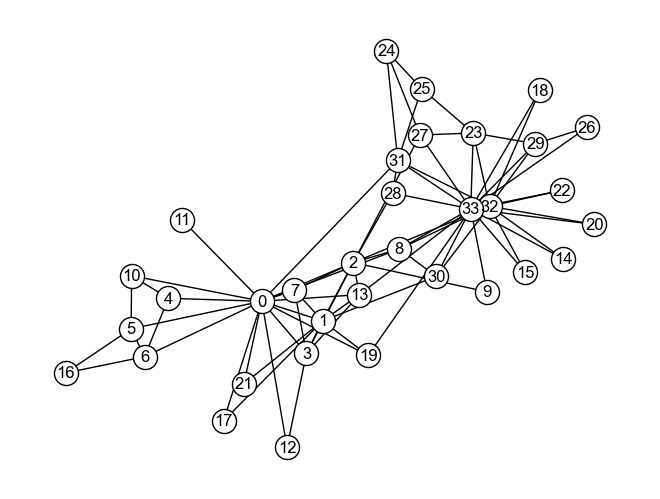

In [8]:
KARATE_DRAW_CONFIG = {
    'edgecolors': 'black', # line color of nodes
    'with_labels': True,
    'node_size': 300,
    'font_size': 12,
    'font_family': 'Arial',
}

G_karate = nx.karate_club_graph()
pos = nx.spring_layout(G_karate, seed=123)
nx.draw(G_karate, pos, **KARATE_DRAW_CONFIG, node_color='white', font_color='black')

まずはノードの埋め込みを得よう．
1つ前の節で説明したように，スペクトラルクラスタリングで埋め込みを得るには，グラフラプラシアンから固有値ベクトルを取得し，埋め込みの次元数分だけ固有ベクトルを並べた行列を得る．
この例では，埋め込みの次元数を`2`としてみよう．
以下，埋め込みを得るコードである．

In [9]:
# グラフの定義
G_karate = nx.karate_club_graph()

# グラフラプラシアンを得る
L = nx.laplacian_matrix(G_karate).toarray()

# 埋め込み次元数
dim = 2

# ゼロでない2つの最少の固有値に対応する固有ベクトルを並べて行列（X_sc）とする
target_component_idx = np.linalg.eig(L).eigenvalues.argsort()[1:dim+1]
X_karate = np.linalg.eig(L).eigenvectors[:, target_component_idx]

`X_karate`に各ノードの特徴を表す埋め込みベクトルが納められている．
`X_karate`はNumPy形式の行列であるため，scikit-learnライブラリで提供されている各種汎用機械学習技術に簡単にツッコむことができる．
今回はK-means法でクラスタリングしたかったので，以下のコードを実行する．

In [10]:
from sklearn.cluster import KMeans

# K-means
kmeans_results = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_karate)

# クラスタ番号が入ったリスト．リストの順序はノードの順序（G_karate.nodes）に対応
clusters_predicted = kmeans_results.labels_

ご覧の通り，一度埋め込みベクトルが得られてしまえば，お馴染みのscikit-learnがよしなにしてくれる．
最後に，以下のコードを実行してクラスタリング結果を可視化してみよう．

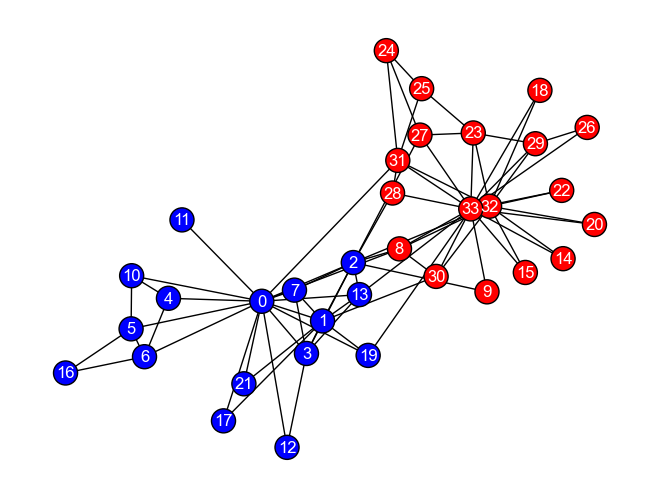

In [11]:
# クラスタ番号ごとに色を割り当てる
colors = {0: 'red', 1: 'blue'}
clusters_predicted = [colors[c] for c in clusters_predicted]

# グラフに色づけをする
nx.draw(G_karate, pos, **KARATE_DRAW_CONFIG, node_color=clusters_predicted, font_color='white')

## ランダムウォークによるノード埋め込み

スペクトラルクラスタリングによるノードの埋め込みは，グラフにおけるノードの隣接関係に着目した埋め込み手法であった．
それに対して，この章で学ぶ「ランダムウォークによるノード埋め込み」の手法は，自然言語処理における単語の埋め込みに着想得た手法である．

### 単語埋め込み

**単語埋め込み（word embedding）** は，単語の潜在的な意味を捉えるために単語を低次元の密ベクトルに変換する技術である．
良質な単語埋め込みを得ることができれば，ベクトル空間上で単語の意味の類似性評価や単語の関係演算を行うことができる．

![](img/word-embedding.jpg)

良質な単語埋め込みを得るための著名な方法のひとつが**Word2Vec**である．
[Word2Vec](https://ja.wikipedia.org/wiki/Word2vec)は，「単語の意味はその周囲に現れる単語によって決まる」というHarrisの分散仮説にもとづき，ある文脈から予想される単語（あるいは，ある単語が登場する文脈に出現する単語）を予測する問題をニューラルネットワークで解くことで，単語の埋め込み表現を得る．
具体的には，ある単語の埋め込みベクトルからその単語の文脈（周辺に現れる単語），あるいは指定された文脈からその文脈に現れる（マスクされた）単語を予想できるよう，大量の文書を使って単語の埋め込みを学習する．
なお，`gensim`は，PythonでWord2Vecを実行する際によく使われる外部ライブラリである．

![](img/word2vec.jpg)

Word2Vecは大量の文，すなわち単語の系列から単語の埋め込み表現を学習する強力な手法である．
このWord2Vecに着想を得て，こう閃いた研究者がいた — もしグラフを何らかの手法でノードの系列に変換できれば，Word2Vecを応用して単語と同じようにノードの埋め込み表現を得られるのでは？

### グラフ上のランダムウォーク

グラフ上の**ランダムウォーク（random walk）** とは，グラフ上あるノードを始点として，「対象ノードの隣接ノードから移動先ノードをランダムにひとつを選択し移動をする」という操作を繰り返すプロセスである．
重みなしグラフの場合，どの隣接ノードに遷移するかは一様分布に従い確率的に決定する．
重みなしグラフの場合は，移動元ノードと隣接ノードを結ぶエッジの重みを考慮して，遷移先を確率的に決定する．

以下は，グラフ$G$上をランダムウォークする様子を示したものである．
ランダムウォークによる移動過程は，ノードの系列として表現できる．
密な繋がりをもつノードは頻繁に訪れることになる一方，繋がりに乏しいノードはランダムウォークでも訪問可能性が少なくなる．
そのため，ノード$i$に繋がりが深いノードは，ランダムウォークで生成したノード系列においても，ノード$i$の周辺に頻出すると考えられる．



In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from IPython.display import HTML

RANDOM_WALK_DRAW_CONFIG = {
    'edgecolors': 'black', # line color of nodes
    'with_labels': True,
    'node_size': 600,
    'font_size': 14,
    'font_family': 'Arial',
}

# グラフの定義
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
G.add_edges_from([
    (0, 1), (0, 2), (0, 4), (1, 2), (1, 4), (2, 3), (2, 4),
    (3, 4), (4, 5), (5, 7), (7, 6), (7, 9),
    (6, 9),
    (5, 10), (8, 10)
])

# グラフのレイアウトを固定
pos = nx.spring_layout(G, seed=12345)

# ランダムウォークのパラメータ
start_node = 8
num_steps = 50
current_node = start_node


# アニメーションの設定
fig, ax = plt.subplots(figsize=(8, 6))

# グラフの初期描画（最初のフレームの準備）
node_colors = ['white'] * G.number_of_nodes()
node_colors[8] = 'lightgray'
nx.draw(G, pos, **RANDOM_WALK_DRAW_CONFIG, node_color=node_colors)
ax.axis('off') # 軸を非表示にする

# アニメーションの更新関数
def update(frame):
    global current_node

    ax.clear() # 前のフレームをクリア

    # 次のノードを選択（ランダムウォーク）
    neighbors = list(G.neighbors(current_node))
    next_node = random.choice(neighbors)

    current_node = next_node

    # ノードの色を更新
    node_colors = ['white'] * G.number_of_nodes()
    for i, node in enumerate(G.nodes()):
        if node == current_node:
            node_colors[i] = 'lightgray'

    # グラフの再描画
    nx.draw(G, pos, **RANDOM_WALK_DRAW_CONFIG, node_color=node_colors, ax=ax)
    ax.axis('off') # 軸を非表示にする

# アニメーションの作成
ani = animation.FuncAnimation(
    fig,
    update,
    frames=num_steps,
    repeat=False, # アニメーションを繰り返さない
    interval=300 # 各フレーム間のミリ秒（0.5秒）
)

# HTMLを表示
html_animation = ani.to_jshtml()
plt.close(fig)
HTML(html_animation)

### DeepWalk

グラフに属するノードからランダムに出発ノードを選び，そのノードからランダムウォークを繰り返すことで，任意の長さのノード系列を無限に生成することができる．
**DeepWalk** は，ランダムウォークによってノード系列し，ノードを単語，ノード系列を単語系列（文）と見なしてWord2Vecを適用することで，ノードの埋め込み表現を得る手法である（[論文](https://dl.acm.org/doi/10.1145/2623330.2623732)）．
例えば，上のグラフ$G$のノード0を始点としてランダムウォークを5回実行した結果，0→2→0→4→5と移動した場合，`(0, 2, 0, 4, 5)`が長さ5のノード系列となる．
このようなノード系列を大量に生成し，それを学習データとしてWord2Vecでノードの埋め込みを学習する．

以下，DeepWalkの具体的な手順である:
1. グラフGのノード集合$V$からノード$v$を取得
2. ノード$v$を起点としたランダムウォークを行い，長さ$T$のノード系列$l$を得る
3. ステップ1-2をノード集合$V$のすべてのノードに対し$N$回繰り返しノード系列集合$L=\{l_1, l_2, ..., l_N\}$を得る
4. ノード系列集合$L$に対してWord2Vec（with skip-gram model）を適用する

上の説明で用いたグラフ$G$にDeepWalkを適用してみよう．
まず最初に，ランダムウォークによって長さ`10`のノード系列を十分な数だけ生成する
（なお，長さや生成するノード系列の大きさは，対象とするタスクに応じて調整する必要がある）．
ランダムウォークによるノード系列生成は，以下のようにNetworkXの`generate_random_paths`関数を用いて簡単に行うことができる．


In [13]:
walks_per_node = 100 # 始点ノード1つあたり，いくつノード系列を生成するか
path_length = 10 # ノード系列の長さ

paths = []

# 以下はPython 3.11 & NetworkX 3.5の組み合わせ
# グラフ中の各ノードを始点としてランダムウォーク
# for node in G.nodes():
#     # 引数にsourceを指定すると，そのノードを始点としたランダムウォークを実行する
#     _paths = list(nx.generate_random_paths(G, sample_size=walks_per_node, source=node, path_length=path_length))
#     paths += _paths

# 以下はPython <= 3.10 & NetworkX 3.4xの組み合わせ
# NetworkX 3.4以下 は generate_random_pathsにsource引数がないので，始点ノードをランダムに選ぶしかない
paths = list(nx.generate_random_paths(G, sample_size=walks_per_node * G.number_of_nodes(), path_length=path_length))

学習データとなるノード系列が得られれば，あとはデータをWord2Vecに食わせればよい．
PythonでWord2Vecを実行する著名なライブラリである`gensim`は，単語を含めた任意のデータ系列のリストを入力としてデータの埋め込みを学習することができる．
Word2Vec実行時には，以下に関するパラメータを設定する必要がある:

- `vector_size`: 埋め込みベクトルの次元数
- `window`: ターゲットとする文脈の長さ（単語の出現予測を行う際に，その単語の周囲何語を予測に使うか）
- `min_count`: 埋め込み計算対象とする単語の出現頻度の閾値．この値を下回った語は計算対象としない
- `epoch`: 学習のループ回数．多すぎると過学習する

以下はグラフ$G$に対して，埋め込みベクトル時の次元数を`8`，ウィンドウサイズを`5`，単語出現頻度の閾値を`0`，学習のループ回数を`5`に設定してDeepWalk（ノード系列 + Word2Vec）を適用したコード例である．

In [14]:
from gensim.models import Word2Vec

model = Word2Vec(paths, vector_size=4, window=5, min_count=0, epochs=5)

学習後，モデル（`model`）を通じてノードの埋め込みベクトルを取得できる．
例えば，ノード番号4のノードの埋め込みを取得するには，

In [15]:
model.wv[4]

array([ 0.81077987, -1.2316959 ,  0.75968015,  0.63260365], dtype=float32)

とする．
埋め込みベクトルさえ得られれば，あとはベクトルを対象とした様々な計算を行うことができる．
例えば，4番目のノードと5番目のノードのコサイン類似度を計算したい場合は，以下のように`cosine_similarity`関数を定義することで計算することができる．

In [16]:
import numpy as np

# コサイン類似度の定義
def cosine_similarity(v1, v2):
    inner_product = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1, ord=2)
    norm2 = np.linalg.norm(v2, ord=2)
    return inner_product / (norm1 * norm2)

# ノード4とノード5のコサイン類似度．隣り合うこともあり，類似度は高くなる
cosine_similarity(model.wv[4], model.wv[5])

0.46246472

### Node2Vec

DeepWalkはグラフ埋め込みに自然言語処理の分野で開発された手法を取り込む画期的なアイデアであったが，いくつかの問題があった．
主要な問題のひとつは**サンプリングされるノードの偏り**である．
ランダムウォークによるノード系列サンプリングでは，一部のノードの出現頻度に意図しない偏りが発生する可能性がある．
別の問題としては，DeepWalkはグラフ構造の局所性に敏感なことが挙げられる．
単純なランダムウォークは，出発ノードの近傍ノードを中心にサンプリングされてしまう．
タスクによっては，グラフの居所的な構造よりも大域的な構造を捉えたい場合もありえる．

このような問題の解決に取り組んだのが**Node2Vec**アルゴリズムである（[論文](https://arxiv.org/abs/1607.00653)）．
Node2VecはDeepWalkの改良版（一般化）である．
以下は，Node2Vecによるノード埋め込みの手順である:

1. ランダムウォークパラメータ`p`および`q`を設定する
2. グラフGのノード集合$V$からノード$v$を取得
3. ノード$v$を起点とした**調整ランダムウォーク**を行い，長さ$T$のノード系列$l$を得る
4. ステップ2-3をノード集合$V$のすべてのノードに対し$N$回繰り返しノード系列集合$L=\{l_1, l_2, ..., l_N\}$を得る
5. ノード系列集合$L$に対してWord2Vec（with skip-gram model）を適用する

ご覧の通り，ステップ1と3以外はDeepWalkと同じである．
違いは，Node2Vecではノード系列をサンプリングする際，純粋なランダムウォークではなく調整された（意図的にある偏りを持たせた）ランダムウォークを行う．
調整されたランダムウォークでは，ランダムウォークを`t-1`回続けた後に到達したノードを$v_{t-1}$，次に遷移したノード（つまり`t`回目の調整済みランダムウォーク後に到達したノード）を$v_t$としたとき，`t+1`回目の遷移先を遷移確率$Pr(v_{t+1}|v_t)$に従い確率的に決める．
遷移確率$Pr(v_{t+1}|v_t)$の定義は以下の通り:

$$
Pr(v_{t+1}|v_t) = \frac{\pi_{v_t,v_{t+1}}}{\sum_{v \in LinkedFrom(v_t)}\pi_{v_t,v}}
$$

ただし，
$$
\pi_{v_t,v_{t+1}} =
\begin{cases}
\frac{1}{p}  & (v_t,v_{t+1}) \in E \ かつ \ d(v_{t-1},v_{t+1})=0 \\
1 & (v_t,v_{t+1}) \in E \ かつ \ d(v_{t-1},v_{t+1})=1 \\
\frac{1}{q} & (v_t,v_{t+1}) \in E \ かつ \ d(v_{t-1},v_{t+1})=2
\end{cases}
$$
また，$d(v_x,v_y)$はノード$v_x$と$v_y$の距離を意味する．
上の式だけを見てもすぐに意味分からないが，

- パラメータ$p$は1ステップ前のランダムウォークで遷移したノードへの戻りやすさ（再訪性），
- パラメータ$q$は幅優先探索的なランダムウォークのしやすさ（探索の方向性）

を制御するものである．
以下の図と照らし合わせながら確認してほしい．
$q$の値を1より大きくするとランダムウォークが幅優先探索的な振る舞いに，1より小さくすると深さ優先探索的な振る舞いになる．
ちなみに$p=q=1$とするとDeepWalkと等価になる．

![](img/node2vec.jpg)

深さ優先探索的なランダムウォークと幅優先探索的なランダムウォークは，捉えられるノードの特徴は異なるのだろうか？
これについては，node2vecの[オリジナル論文](https://arxiv.org/abs/1607.00653)の中で言及されている．
以下の図は論文から引用したものであるが，深さ優先探索的なランダムウォークは始点から離れるように遷移するので，得られるノード系列にはノード間の大域的な関係性が現れると考えられる．
それゆえ，グラフ全体を俯瞰したときにノードがどのコミュニティに属しているのかという観点からノード埋め込みを行いたい場合，深さ優先探索的なランダムウォークで得られたノード系列を用いてnode2vecを実行するのがよいとされている．
一方，幅優先探索的なランダムウォークは始点の周りを探るように遷移するので，得られるノード系列にはノード間の局所的な関係性が現れると考えられる．
そのため，他のノードとの接続パターン（構造的同値性）の観点からノードの埋め込みを行いたい場合，幅優先探索的なランダムウォークで得られたノード系列を用いてnode2vecを実行するのがよいとされている．

以上はnode2vecのオリジナル論文で言われていることであるが，ランダムウォークの振る舞いを制御する`p`と`q`のパラメータ，およびサンプリングするノード系列の長さのパラメータの設定はかなりシビアであるので，タスクに応じて慎重に設定する必要がある．

![](img/dfs-vs-bfs.jpg)

最後に，空手クラブのグラフ$G_{karate}$にnode2vecを適用し，ノードをクラスタリングしてみよう．
スペクトラルクラスタリングの節ではノードを2つのクラスタに分割したが，今回は3つのクラスタに分けてみよう．
(1) node2vecでノードを埋め込み，(2) K-means法でクラスタリング，と運びとしよう．

Pythonで高度なグラフ機械学習を行うライブラリとして，[PyTorch Geometric（通称PyG）](https://pytorch-geometric.readthedocs.io/)がある．
以下はPyGを使って，グラフ$G_{karate}$のノードの埋め込みを得るコードである．
今回はコミュニティを抽出したいので，ランダムウォークのパラメータとして$p=2$，$q=0.5$として深さ優先探索的なランダムウォークを行うようにした．
また，学習の回数（`epoch`数）は100とした（学習データ数が少ないので，結果を安定させるために`epoch`数を多めに設定）．

In [17]:
import torch
import torch_geometric
from torch_geometric.nn import Node2Vec

# 乱数を固定
seed_id = 12345
torch.manual_seed(seed_id)

# グラフの定義
G_karate = nx.karate_club_graph()

# NetworkXのグラフをPyGで扱えるように変換
karate_dataset = torch_geometric.utils.convert.from_networkx(G_karate)

# node2vecの設定
model = Node2Vec(
    karate_dataset.edge_index, # 埋め込み対象となるグラフのエッジ情報
    embedding_dim=4, # 埋め込みベクトルの次元数
    walks_per_node=80, # ノードひとつにつきランダムウォークで生成するノード系列の数
    walk_length=10, # ノード系列の長さ
    context_size=5, # word2vecを実行する際の，文脈の大きさ（周囲何ノードを対象とするか）
    p=2, # pパラメータ
    q=0.5, # qパラメータ
)

# -----------------
# 学習フェーズ
# -----------------
epoch_num = 100

# 微分最適化アルゴリズム
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 学習データの読み込み方法
loader = model.loader(batch_size=32, shuffle=True, num_workers=0)

# 学習
for epoch in range(epoch_num):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw, neg_rw) # 誤差の計算
        loss.backward() # 誤差逆伝播
        optimizer.step() # パラメータ更新
        total_loss += loss.item()
    train_loss = total_loss / len(loader)
    
    if epoch % 20 == 0:
        print(f'Epoch: {epoch}, Train-loss: {train_loss:.4f}')


# -----------
# 埋め込みの取得
# -----------
# モデルを推論モードに切り替え
model.eval() 

# 行列を得る
X_n2v = model().detach().numpy()

Epoch: 0, Train-loss: 1.7941
Epoch: 20, Train-loss: 1.4424
Epoch: 40, Train-loss: 1.3260
Epoch: 60, Train-loss: 1.2491
Epoch: 80, Train-loss: 1.1972


node2vecによる埋め込みベクトルが得られたので，スペクトラルクラスタリングの時と同様に，scikit-learnでK-meansクラスタリングを実行しよう．
最後に，以下のコードを実行してクラスタリング結果を可視化してみよう．

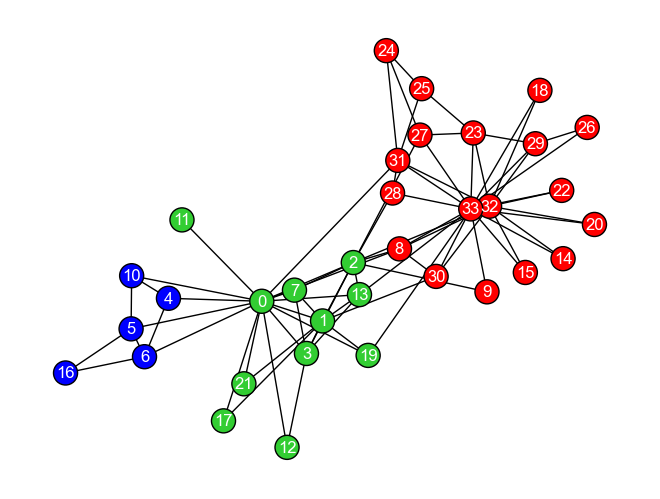

In [18]:
from sklearn.cluster import KMeans

# クラスタリング
kmeans = KMeans(n_clusters=3, random_state=12345, n_init="auto").fit(X_n2v)
clusters_predicted = kmeans.labels_

# 3つのクラスタを3色で塗り分け
colors = {0: 'red', 1: 'blue', 2: 'limegreen'}
clusters_predicted = [colors[c] for c in clusters_predicted]

# 可視化
pos = nx.spring_layout(G_karate, seed=123)
nx.draw(G_karate, pos, **KARATE_DRAW_CONFIG, node_color=clusters_predicted, font_color='white')

---

## クイズ

### Q1: ランダムウォーク

以下のグラフ$G_{maze}$において，任意のノードからスタートし，ランダムウォークを$L$回したときの経路を得る関数`get_random_walk_path`を定義しなさい．
関数`get_random_walk_path`の引数はグラフ`G`，出発ノード`node_from`，経路の長さ（ランダムウォークの回数）`length`とし，返り値は`[0, 4, ..., 3]`のようなノードのリストとすること．
なお，このクイズではNetworkxの`generate_random_paths`関数は用いないこと．

※ ヒント: あるノードに隣接するノードのリストを得るには，Networkxのグラフオブジェクトの`neighbors`メソッドを用いればよい．
またリストからランダムに要素を取得するには`random`パッケージの`choice`メソッドを用いればよい．

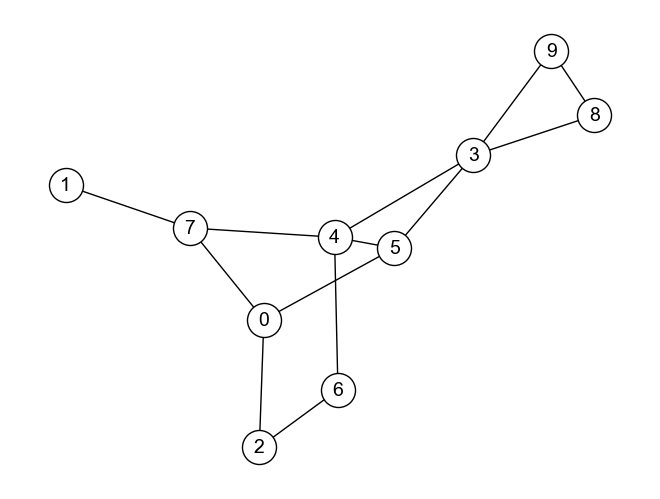

In [19]:
G_maze = nx.sedgewick_maze_graph()
G_maze.add_edges_from([(3, 8), (3, 9), (8, 9)])
pos = nx.spring_layout(G_maze, seed=123)
nx.draw(G_maze, pos, **DRAW_CONFIG)

In [ ]:
# Write your code
def get_random_walk_path(G, node_from, length):
    ''' node_from: グラフG上でランダムウォークを開始するノード
        length: ランダムウォークして得る経路の長さ
    '''


# # グラフを定義
# G_maze = nx.sedgewick_maze_graph()

# # 定義した関数を用いて経路を得る
# get_random_walk_path(G_maze, node_from=1, length=10)

### Q2: node2vecのためのランダムウォーク

クイズQ1で定義した`get_random_walk_path`関数を改良し，node2vecアルゴリズムに従うランダムウォーク経路を生成する関数`get_random_walk_path_for_n2v`を定義しなさい．
なお，関数`get_random_walk_path_for_n2v`の引数として以下を設定しなさい．
- G: グラフ
- node_from: 経路の始点となるノード
- length: 経路の長さ
- p: 再訪性パラメータ（float型）
- q: In-outパラメータ（float型）

※ ヒント: 指定した重み（確率分布）に従ってリストから要素を取得するには，`random`パッケージの`choices`関数を用いる（[参考](https://docs.python.org/ja/3.13/library/random.html#random.choices)）．

In [ ]:
import random

# Write your code
def get_random_walk_path_for_n2v(G, node_from, length, p: float=1, q: float=1):
    ''' node_from: グラフG上でランダムウォークを開始するノード
        length: ランダムウォークして得る経路の長さ
    '''
         

# # グラフを定義
# G_maze = nx.sedgewick_maze_graph()

# # 定義した関数を用いて経路を得る
# path = get_random_walk_path_for_n2v(G_maze, node_from=1, length=4, p=1, q=0.01)
# path

### Q3: 論文ジャンルの分類（1/2） - 埋め込みベクトルの獲得

[Cora](https://paperswithcode.com/dataset/cora)は論文公開サイト[arXiv](https://arxiv.org)で公開されている機械学習分野の論文の一部を抽出したデータセットである．
データセットには，論文の引用関係（どの論文がどの論文を引用したか）や論文のキーワード情報に加えて，各論文の分野カテゴリを示すラベル情報が含まれている．
分野カテゴリラベルは0から6までの整数値のいずれかをとり，各数値に対応する分野は以下の通りである：

0. Case based
1. Genetic algorithm
2. Neural network
3. Probabilistic method
4. Reinforcement learning
5. Rule learning
6. Theory

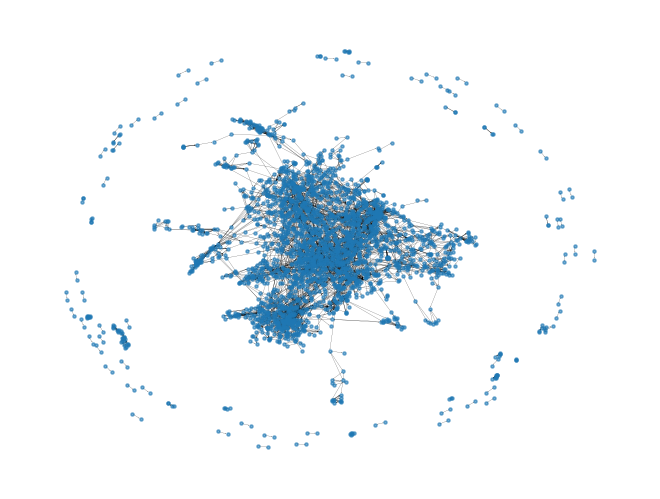

In [20]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import to_networkx

# paper_datasetはPyGで扱えるグラフのデータ構造
paper_dataset = Planetoid(root="tmp", name="cora", split='full')

# NetworkXのグラフデータ構造に変換
G_paper = to_networkx(paper_dataset._data)

# 表示位置を調整して可視化
pos = nx.forceatlas2_layout(G_paper, seed=1234)
nx.draw(G_paper, pos, node_size=5, width=0.1,
        alpha=0.6, arrowsize=1, with_labels=False)

分野カテゴリが未知の論文について，そのカテゴリを推定する分類器を機械学習で構築したいとしよう．
第1ステップとして，論文の引用関係から引用関係グラフを構築し，グラフ構造とnode2vecを用いて各論文の埋め込みベクトルを得たい．
以下のPythonコードを追記，修正して，論文の埋め込みベクトルを獲得しなさい．

なお，node2vecのパラメータは以下とする:
- `embedding_dim`: 64
- `walks_per_node`: 10
- `walk_length`: 10
- `context_size`: 5
- `p`および`q`: 任意
- `epoch_num`（学習ループ回数）: 20

In [ ]:
from torch_geometric import datasets
import torch
import torch_geometric
from torch_geometric.nn import Node2Vec

# データの読み込み．以下のコードで読み込めば，PyGライブラリで扱えるグラフデータ形式になっている
paper_dataset = datasets.Planetoid(root="tmp", name="cora", split='full')

# node2vecの設定
model = Node2Vec(
    paper_dataset.edge_index, # 埋め込み対象となるグラフのエッジ情報

    # ---------------------------
    # Write your codes below
    # ---------------------------

    
)

# -----------------
# 学習フェーズ
# -----------------
epoch_num = 20

# 微分最適化アルゴリズム
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 学習データの読み込み方法
loader = model.loader(batch_size=32, shuffle=True, num_workers=0)

# 学習
for epoch in range(epoch_num):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw, neg_rw) # 誤差の計算
        loss.backward() # 誤差逆伝播
        optimizer.step() # パラメータ更新
        total_loss += loss.item()
    train_loss = total_loss / len(loader)
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, Train-loss: {train_loss:.4f}')

# -----------
# 埋め込みの取得
# -----------
# モデルを推論モードに切り替え
model.eval() 

# ノード埋め込みベクトル（行列）を得る
X_n2v = model().detach().numpy()

### Q4: 論文ジャンルの分類（2/2） - 分類器の構築

Q3で得たノードの埋め込みベクトルとcoraデータセットの論文カテゴリラベルを用いて，論文のカテゴリを推定する分類器を構築したい．
ベクトルデータを入力とする機械学習手法を用いて分類器を構築し，5分割交差検証を用いて構築した分類器のマクロ適合率，マクロ再現率，マクロF1値を算出しなさい．
なお，用いる機械学習手法は自由とする．

##### ヒント1
マクロ適合率（再現率，F1値）とは，他クラス分類問題の性能評価に用いられる評価基準である．
クラスごとに適合率（再現率，F1値）を計算した後，それらの平均値を取ることで算出する．
Pythonのscikit-learnライブラリを用いれば，以下のように簡単に計算できる．

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_predicted = [0, 1, 2, 0, 0, 0, 2, 1, 1] # 予想されたクラスのリスト
y_test = [0, 1, 2, 0, 1, 2, 0, 2, 2] # 正解クラスのリスト

# 評価スコアの計算
precision = precision_score(y_test, y_predicted, average='macro')
recall = recall_score(y_test, y_predicted, average='macro')
f1 = f1_score(y_test, y_predicted, average='macro')

print(f"Macro precision: {precision}")
print(f"Macro recall: {recall}")
print(f"Macro F1-score: {f1}")

##### ヒント2

Coraデータセットに含まれる各論文の分野カテゴリラベルは，以下のコードで取り出すことができる．

In [ ]:
from torch_geometric.datasets import Planetoid

# paper_datasetはPyGで扱えるグラフのデータ構造
paper_dataset = Planetoid(root="tmp", name="cora", split='full')

# 分野カテゴリラベル情報を取り出す
y = paper_dataset.y

y